In [1]:
%matplotlib widget
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import simple_pinn
import utils
import cv_mesh
import cv_solver
import athena_reader

# for dev purposes, reload these modules each time this cell is run
import importlib
importlib.reload(simple_pinn)
importlib.reload(utils)
importlib.reload(cv_mesh)
importlib.reload(cv_solver)
importlib.reload(athena_reader)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu" 

# torch.set_default_dtype(torch.float64)

Let's see if we can recover the adiabatic index from an Athena++ simulation of the Brio and Wu shock tube problem.
The simulation is run with $\gamma = 2.5$ and Gaussian noise (5%) is superimposed on its output.

In [2]:
t_domain = [0.0, 0.1]
x_domain = [-1.0, 1.0]
Nt = 128
Nx = 128
mesh = cv_mesh.CVMesh(
    t_domain, x_domain, Nt, Nx, quad_pts=(4, 4), quad_rule="composite_trapezoid"
)
mesh.to(DEVICE)


# the primitive set here is (rho, v_x, v_y, v_z, B_x, B_y, B_z, E)

# beta is the "dummy" parameter that we actually optimize, so it can range from -inf to inf
beta = nn.Parameter(torch.tensor(3.0, device=DEVICE))


# this function maps beta -> [1, inf), which is what we need for gamam to be well-defined in the EOS
def gamma(beta):
    return torch.nn.functional.softplus(beta) + 1.0


def mhd_ideal_gas_eos(state_vec):
    rho = state_vec[..., 0]
    v_x = state_vec[..., 1]
    v_y = state_vec[..., 2]
    v_z = state_vec[..., 3]
    B_x = state_vec[..., 4]
    B_y = state_vec[..., 5]
    B_z = state_vec[..., 6]
    E = state_vec[..., 7]

    e = torch.divide(
        E
        - 0.5 * rho * (v_x**2 + v_y**2 + v_z**2)
        - 0.5 * (B_x**2 + B_y**2 + B_z**2),
        rho,
    )

    eps = 1.0e-6
    e = torch.clamp(e, min=eps)
    rho = torch.clamp(rho, min=eps)

    s = torch.log(e) / (gamma(beta) - 1.0) - torch.log(rho)
    p = (gamma(beta) - 1.0) * rho * e
    return s, p


def mhd_state_vec_to_fluxes(state_vec, eos):
    rho = state_vec[..., 0]
    v_x = state_vec[..., 1]
    v_y = state_vec[..., 2]
    v_z = state_vec[..., 3]
    B_x = state_vec[..., 4]
    B_y = state_vec[..., 5]
    B_z = state_vec[..., 6]
    E = state_vec[..., 7]

    _, p = eos(state_vec)
    p_star = p + 0.5 * (B_x**2 + B_y**2 + B_z**2)

    F_t = torch.stack([rho, rho * v_x, rho * v_y, rho * v_z, B_x, B_y, B_z, E], dim=-1)
    F_x = torch.stack(
        [
            rho * v_x,
            rho * v_x**2 + p_star - B_x**2,
            rho * v_x * v_y - B_x * B_y,
            rho * v_x * v_z - B_x * B_z,
            torch.zeros_like(rho),
            v_x * B_y - v_y * B_x,
            v_x * B_z - v_z * B_x,
            (E + p_star) * v_x - B_x * (v_x * B_x + v_y * B_y + v_z * B_z),
        ],
        dim=-1,
    )
    return F_t, F_x


def mhd_state_vec_to_entropy_fluxes(state_vec, eos):
    rho = state_vec[..., 0]
    v_x = state_vec[..., 1]

    s, _ = eos(state_vec)

    F_t = (-s * rho).unsqueeze(-1)
    F_x = (-s * rho * v_x).unsqueeze(-1)
    return F_t, F_x


def briowu_ic_state_vec_evaluation(eval_points, eos):
    rho_left, rho_right = 1.0, 0.125
    B_x = 0.75
    B_y_left, B_y_right = 1.0, -1.0
    p_left, p_right = 1.0, 0.1
    E_left = p_left / (gamma(beta) - 1.0) + 0.5 * (B_x**2 + B_y_left**2)
    E_right = p_right / (gamma(beta) - 1.0) + 0.5 * (B_x**2 + B_y_right**2)

    rho = torch.where(eval_points[..., 1] < 0.0, rho_left, rho_right)
    v_x = torch.zeros_like(eval_points[..., 1])
    v_y = torch.zeros_like(eval_points[..., 1])
    v_z = torch.zeros_like(eval_points[..., 1])
    B_x = torch.ones_like(eval_points[..., 1]) * B_x
    B_y = torch.where(eval_points[..., 1] < 0.0, B_y_left, B_y_right)
    B_z = torch.zeros_like(eval_points[..., 1])
    E = torch.where(eval_points[..., 1] < 0.0, E_left, E_right)

    return torch.stack([rho, v_x, v_y, v_z, B_x, B_y, B_z, E], dim=-1)


athena_data = athena_reader.AthenaReader(
    "../scratch/briowu_2.5",
    ("rho", "vel1", "vel2", "vel3", "Bcc1", "Bcc2", "Bcc3", "press"),
)
gamma_used_in_athena = 2.5


def analytic_briowu_soln(eval_points, eos):
    # okay so it's not "analytic" but we can take Athena++ as ground truth for the forward problem here
    athena_state_vec = athena_data(eval_points.cpu()).to(eval_points.device)
    # athena returns (rho, v_x, v_y, v_z, B_x, B_y, B_z, p),
    # but we need to convert p to E
    rho = athena_state_vec[..., 0]
    v_x = athena_state_vec[..., 1]
    v_y = athena_state_vec[..., 2]
    v_z = athena_state_vec[..., 3]
    B_x = athena_state_vec[..., 4]
    B_y = athena_state_vec[..., 5]
    B_z = athena_state_vec[..., 6]
    p = athena_state_vec[..., 7]
    E = (
        p / (gamma_used_in_athena - 1.0)
        + 0.5 * rho * (v_x**2 + v_y**2 + v_z**2)
        + 0.5 * (B_x**2 + B_y**2 + B_z**2)
    )
    athena_state_vec[..., 7] = E
    return athena_state_vec


# read in "synthetic data" from an Athena++ simulation of this problem.
Nt_sample = 16
Nx_sample = 32
t_sample = torch.linspace(t_domain[0], t_domain[1], Nt_sample, device=DEVICE)
x_sample = torch.linspace(x_domain[0], x_domain[1], Nx_sample, device=DEVICE)
T_sample, X_sample = torch.meshgrid(t_sample, x_sample, indexing="ij")
sample_points = torch.stack([T_sample, X_sample], dim=-1)
# adds 5% noise to the Athena++ data
athena_data.set_sample_points(sample_points, noise_level=0.05)


def model_to_athena_data_comparison(model, eos):
    # get the "data" state vector at the (fixed) sample points
    athena_sample_points, athena_state_vec = athena_data.get_sample_state_vec()

    # evaluate the model's outputs on the sample points
    model_output = model(athena_sample_points)

    # Athena++ returns (rho, v_x, v_y, v_z, B_x, B_y, B_z, p), whereas our model returns (rho, v_x, v_y, v_z, B_x, B_y, B_z, E);
    # in principle, however, the provided data and the model outputs could differ even more substantially; the purpose of this
    # function in general is to provide a transformation to one or both so that their direct comparison is meaningful;
    # in this case... we just ignore E and p because I can't get this to work right otherwise
    # _, p = eos(model_output)
    # model_output = torch.cat([model_output[..., :-1], p.unsqueeze(-1)], dim=-1)
    model_output = model_output[..., :-1]
    athena_state_vec = athena_state_vec[..., :-1]

    return model_output, athena_state_vec


model = simple_pinn.BrioAndWuPINN(
    2,
    [64, 64, 64, 64, 64, 64, 64, 64],
    8,
    mesh,
    briowu_ic_state_vec_evaluation,
    mhd_ideal_gas_eos,
    use_bias_in_output_layer=False,
).to(DEVICE)
print(model)

solver = cv_solver.CVSolver(
    mesh,
    model,
    mhd_state_vec_to_fluxes,
    briowu_ic_state_vec_evaluation,
    mhd_ideal_gas_eos,
    state_vec_to_entropy_fluxes=mhd_state_vec_to_entropy_fluxes,
    model_to_data_comparison=model_to_athena_data_comparison,
    analytic_soln=analytic_briowu_soln,
    component_names=["rho", "v_x", "v_y", "v_z", "B_x", "B_y", "B_z", "E"],
)

BrioAndWuPINN(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1-7): 7 x Linear(in_features=64, out_features=64, bias=True)
  )
  (head): Linear(in_features=64, out_features=8, bias=False)
  (activation): ReLU()
)


In [3]:
gamma_history = []


def train(optimizer, n_epochs, entropy_loss_weight=0.0, data_loss_weight=0.0):
    for epoch in range(n_epochs):
        cv_pde_loss, cv_entropy_loss, data_loss = solver.forward()
        optimizer.zero_grad()
        loss = (
            cv_pde_loss
            + entropy_loss_weight * cv_entropy_loss
            + data_loss_weight * data_loss
        )
        loss.backward()
        optimizer.step()
        gamma_history.append(gamma(beta).item())
        if epoch % 500 == 0:
            print(
                f"Epoch {epoch}: PDE loss: {cv_pde_loss.item():.3e}, Entropy loss: {cv_entropy_loss.item():.3e}, Data loss: {data_loss.item():.3e}, gamma = {gamma(beta).item()}"
            )

In [4]:
parameter_groups = [
    {"params": model.parameters(), "lr": torch.tensor(1.0e-3)},
    {"params": beta, "lr": torch.tensor(1.0e-2)},
]

In [5]:
optimizer = optim.Adam(parameter_groups)
train(optimizer, 10_000, data_loss_weight=1.0)

parameter_groups[0]["lr"] = torch.tensor(1.0e-3)
parameter_groups[1]["lr"] = torch.tensor(1.0e-3)
optimizer = optim.Adam(parameter_groups)
train(optimizer, 20_000, entropy_loss_weight=0.1, data_loss_weight=1.0)

parameter_groups[0]["lr"] = torch.tensor(1.0e-4)
parameter_groups[1]["lr"] = torch.tensor(1.0e-4)
optimizer = optim.Adam(parameter_groups)
train(optimizer, 20_000, entropy_loss_weight=0.1, data_loss_weight=1.0)

Epoch 0: PDE loss: 8.179e-02, Entropy loss: 1.082e-02, Data loss: 7.289e+02, gamma = 4.058115005493164
Epoch 500: PDE loss: 1.110e-03, Entropy loss: 3.831e-06, Data loss: 1.006e+01, gamma = 4.449638366699219
Epoch 1000: PDE loss: 5.397e-04, Entropy loss: 6.189e-06, Data loss: 3.082e+00, gamma = 4.151327133178711
Epoch 1500: PDE loss: 4.481e-04, Entropy loss: 7.784e-06, Data loss: 2.810e+00, gamma = 3.631657123565674
Epoch 2000: PDE loss: 3.676e-04, Entropy loss: 8.316e-06, Data loss: 2.592e+00, gamma = 3.15042781829834
Epoch 2500: PDE loss: 3.260e-04, Entropy loss: 8.390e-06, Data loss: 2.531e+00, gamma = 2.8446836471557617
Epoch 3000: PDE loss: 3.078e-04, Entropy loss: 6.965e-05, Data loss: 2.491e+00, gamma = 2.666121482849121
Epoch 3500: PDE loss: 2.471e-04, Entropy loss: 6.512e-05, Data loss: 2.471e+00, gamma = 2.5731515884399414
Epoch 4000: PDE loss: 2.459e-04, Entropy loss: 1.170e-04, Data loss: 2.830e+00, gamma = 2.502777099609375
Epoch 4500: PDE loss: 2.391e-04, Entropy loss: 1.

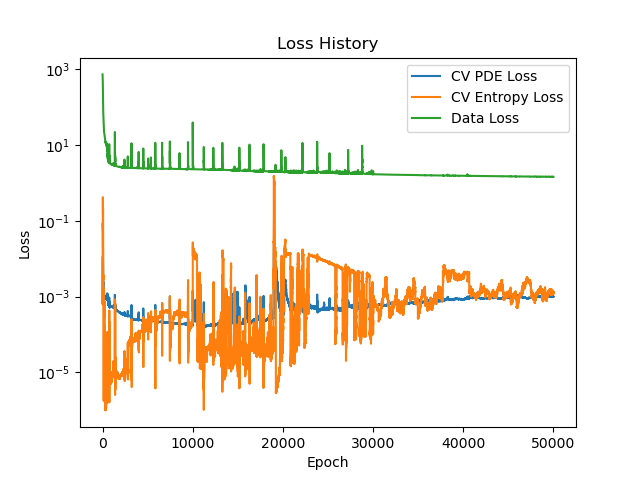

In [6]:
solver.plot_loss_history()

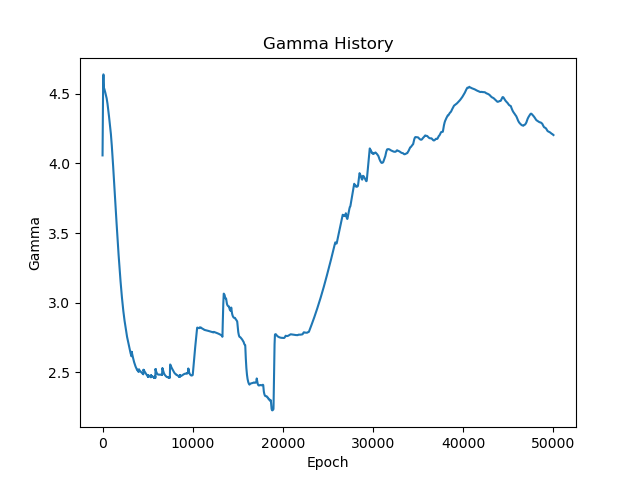

In [12]:
plt.figure()
plt.plot(range(len(gamma_history)), gamma_history)
plt.xlabel("Epoch")
plt.ylabel("Gamma")
plt.title("Gamma History")
plt.show()

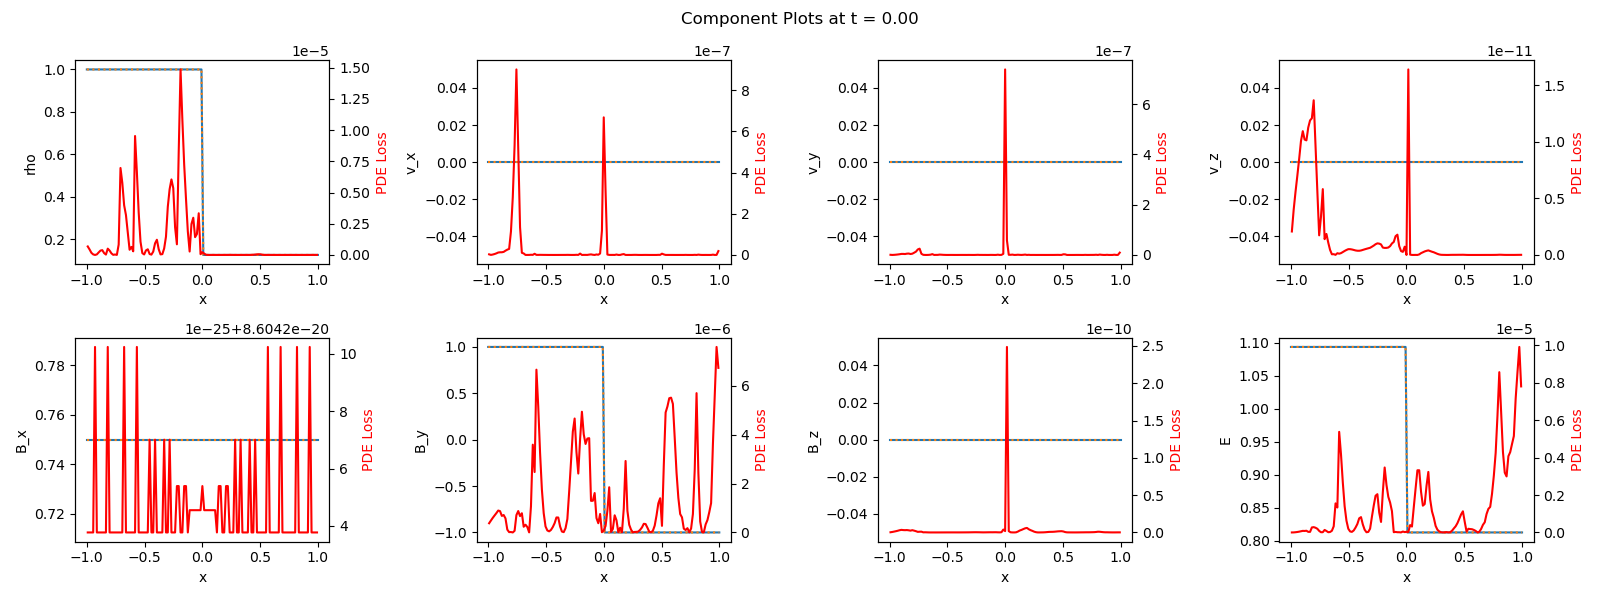

In [7]:
solver.plot_components(
    0,
    num_rows=2,
    num_cols=4,
    centered=False,
    with_ics=True,
    loss_to_plot="PDE",
)

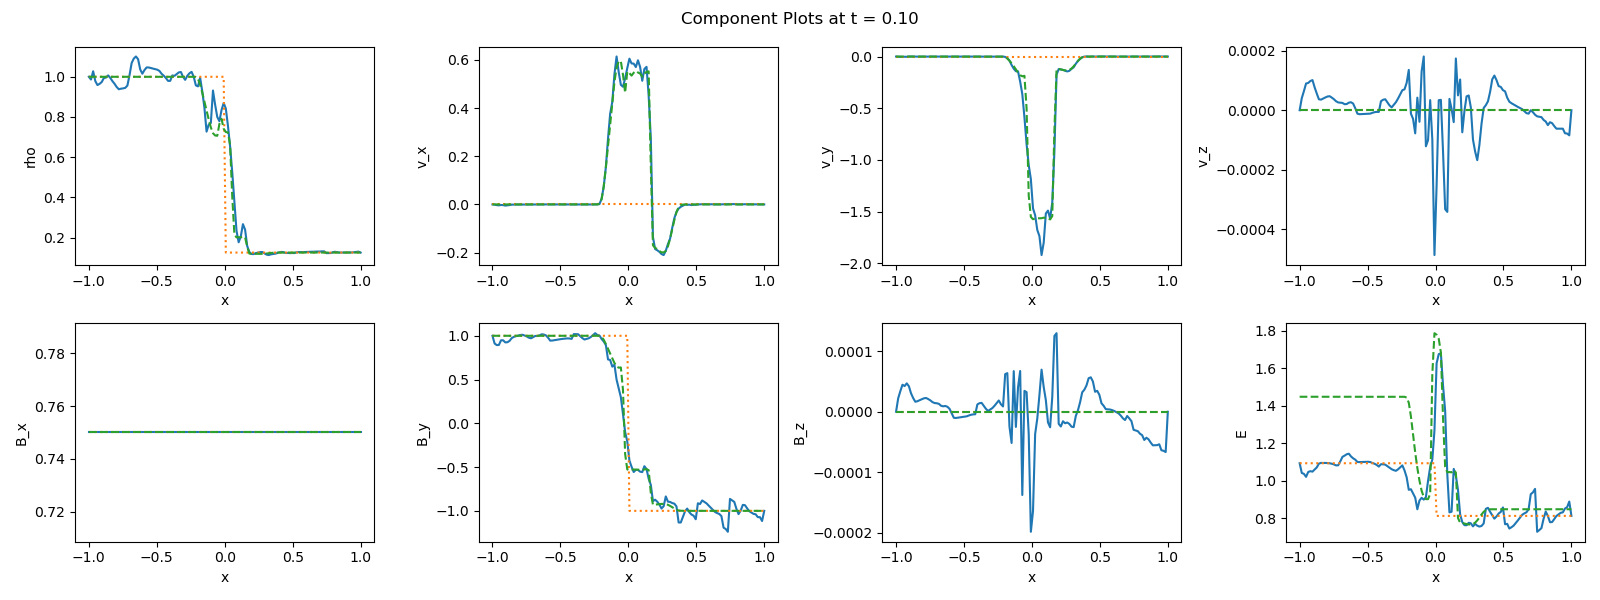

In [10]:
solver.plot_components(
    -1,
    num_rows=2,
    num_cols=4,
    centered=False,
    with_ics=True,
    with_analytic_soln=True,
    # loss_to_plot="PDE",
)

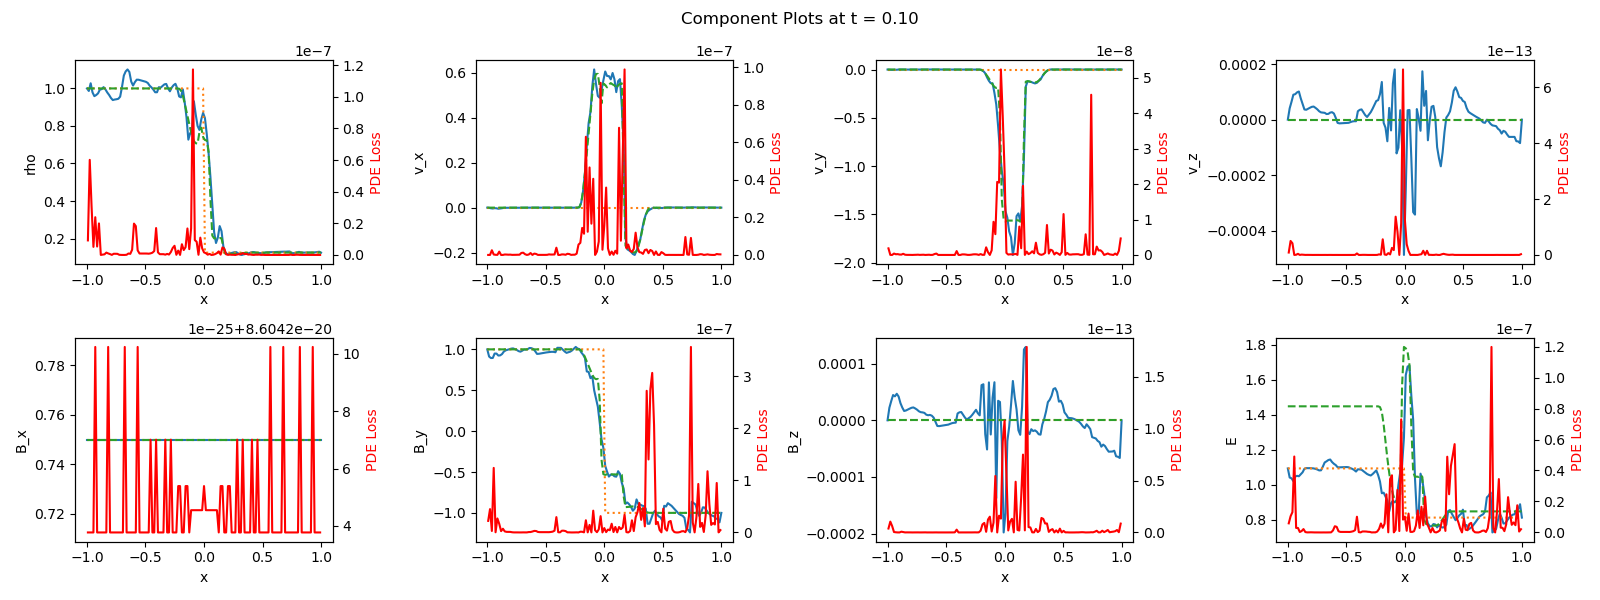

In [11]:
solver.plot_components(
    -1,
    num_rows=2,
    num_cols=4,
    centered=False,
    with_ics=True,
    with_analytic_soln=True,
    loss_to_plot="PDE",
)

In [9]:
# solver.animate_components(
#     "brio_and_wu.gif",
#     num_rows=2,
#     num_cols=4,
#     with_ics=True,
#     with_analytic_soln=True,
# )